In [1]:
# import packages
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from scipy.stats import chisquare

"""
IMPORTANT:
For this program to work the researcher needs to put both csv files
cycle1.csv and cycle2.csv in a folder called Observations. Run
DownloadMongoDB.ipynb to get the files. You will have to manually
put these new files in the Observations folder which will be located
in the same folder as this file.
"""

"""
Headers for Cycle1 DF (Northern Hemisphere):
_id, Original_Object_ID, MDJ, Magnitude, Magnitude_Error

Cycle1 Size: 28878 Asteroids

Headers for Cycle2 DF (Southern Hemisphere):
_id, Object_ID, MDJ, Magnitude, Magnitude_Error, Sector

Cycle2 Size: 18712 Asteroids

Overlap Size: 3025 Asteroids
"""

# import data from csv file into a pandas df
cycle1_df = pd.read_csv("Observations/cycle1.csv", low_memory=False)
cycle2_df = pd.read_csv("Observations/cycle2.csv", low_memory=False)

# get the ids that intersect
cycle1_df_unique = np.unique(cycle1_df["Original_Object_ID"])
cycle2_df_unique = np.unique(cycle2_df["Object_ID"])
intersect_ids = np.intersect1d(cycle1_df_unique, cycle2_df_unique)

# define sine function to fit
def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(frequency * x + phase) + offset

In [ ]:
def find_cycle_asteroids_light_curve_fit(cycle_df, id_col_name):

    # group each asteroid by their object id
    asteroids = cycle_df.groupby(id_col_name)

    count = 0

    # plot each asteroid
    for object_id, asteroid in asteroids:

        """
        Derive the rotational period of an object from MDJ
        and Magnitude.
        """

        # extract MJD, magnitude, magnitude error
        time_mdj = asteroid["MJD"].values
        magnitude = asteroid["Magnitude"].values
        error = asteroid["Magnitude_Error"].values

        # define frequency range (1 to 24 hours period = 1/24 to 1 cycles/hour)
        # convert MJD to hours relative to first timestamp
        time_hours = (time_mdj - time_mdj.min()) * 24
        frequency = np.linspace(1/(max(time_hours) - min(time_hours)), 1/2, 1000000)
        power = LombScargle(time_hours, magnitude, error).power(frequency)

        # best period is 1 / frequency at peak power
        peak_index = np.argmax(power)
        peak_power = power[peak_index]
        best_frequency = frequency[np.argmax(power)]
        best_period = 1 / best_frequency

        # double the period for full rotation
        best_period = best_period * 2

        # create a lomb scargle model generating a sine curve fit
        ls = LombScargle(time_hours, magnitude, error)
        magnitude_fit = ls.model(time_hours, best_frequency)
        time_fit = np.linspace(0, best_period, len(magnitude_fit))
        magnitude_fit = ls.model(time_fit, best_frequency)
        phase = (time_hours % best_period)

        """
        IMPORTANT:
        best_period is the period
        amplitude is calculated below
        """

        # find the max and mind of magnitude fit for the amplitude
        amplitude = max(magnitude_fit) - min(magnitude_fit)

        # determine how well the model fits the data (use the power value (max) and the chi squared value)
        chi2_statistic, _ = chisquare(magnitude, f_exp=magnitude_fit)
        score = (peak_power + 1E-6) / (chi2_statistic + 1E-6)
        print(f"Chi2: {chi2_statistic}")
        print(f"PeakPower: {peak_power}")
        print(f"Score: {score}")

        # is this interesting or not? - interesting, not interesting, garbage

            # fewer than 50? Throw out

        # save data into csv file

        """
        Plot the periodogram and the lomb scargle model (Commented out)
        """

        # plot the periodogram
        plt.plot(frequency, power)
        plt.show()

        # plot the lomb scargle model need to add the magnitude fit
        plt.plot(time_fit, magnitude_fit, color = "orange", linewidth = 3)
        plt.scatter(phase, magnitude, color="blue")
        plt.title(f"Light Curve Phase for: {object_id}")
        plt.xlabel("Hours")
        plt.ylabel("Magnitude")
        plt.gca().invert_yaxis()
        plt.grid(True)
        plt.show()

        """
        Plotting the raw time series data (Commented out)
        """

        # plot the timeseries data
        # plt.errorbar(asteroid["MJD"], asteroid["Magnitude"], yerr = asteroid["Magnitude_Error"], 
        #              fmt = "o", ecolor = "red", color = "orange", elinewidth = 1, capsize = 2)
        # plt.title(f"Magnitude vs MJD for Object ID {object_id}")
        # plt.xlabel("MJD")
        # plt.ylabel("Magnitude")
        # plt.gca().invert_yaxis()
        # plt.grid(True)
        # plt.show()

        count += 1

        # display the first 10
        if count > 10:
            break


Chi2: -0.8614754309611332
PeakPower: 0.6650512834399298
score: -0.7719930615908608


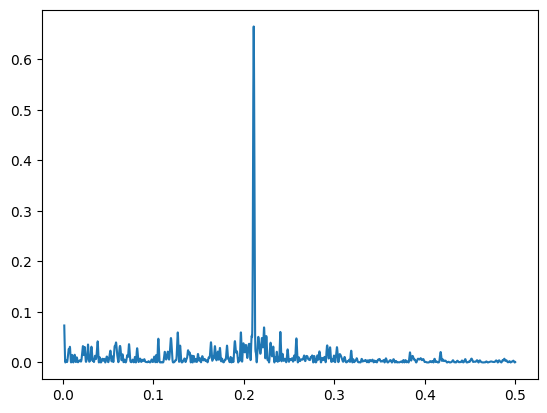

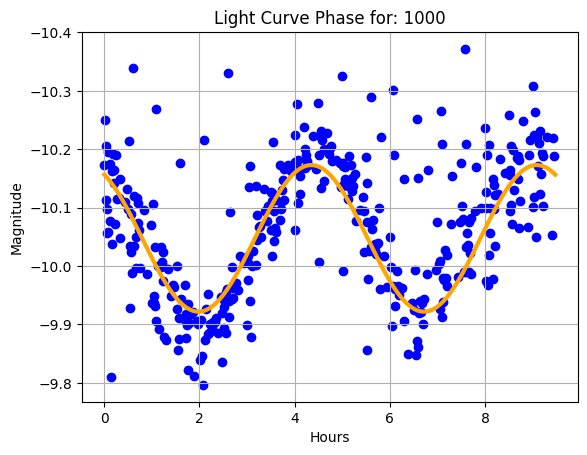

Chi2: -3.7260891343949636
PeakPower: 0.2954250541905464
score: -0.07928584712302228


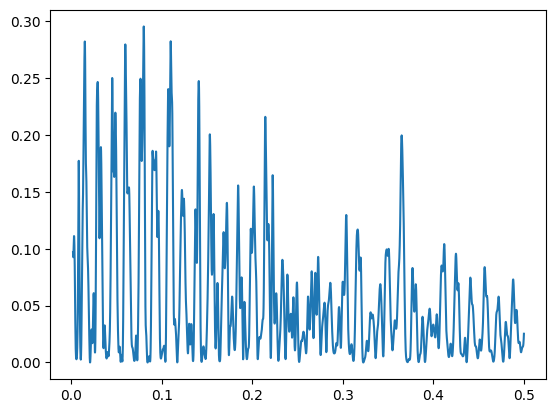

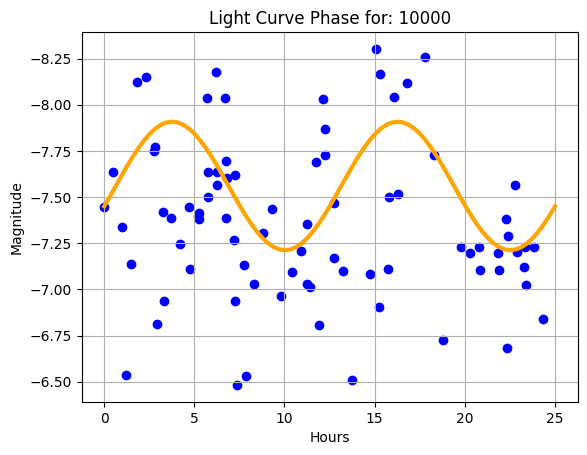

Chi2: -18.790922519808213
PeakPower: 0.2207770574461949
score: -0.011749187351640234


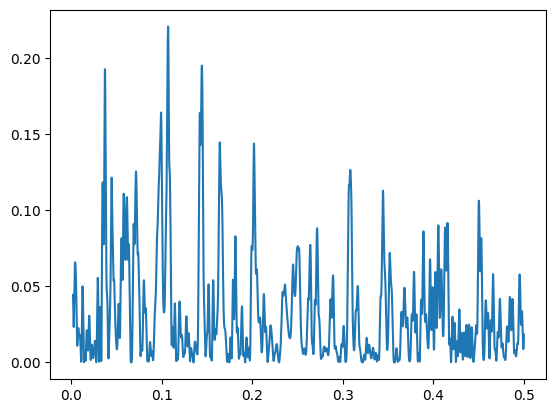

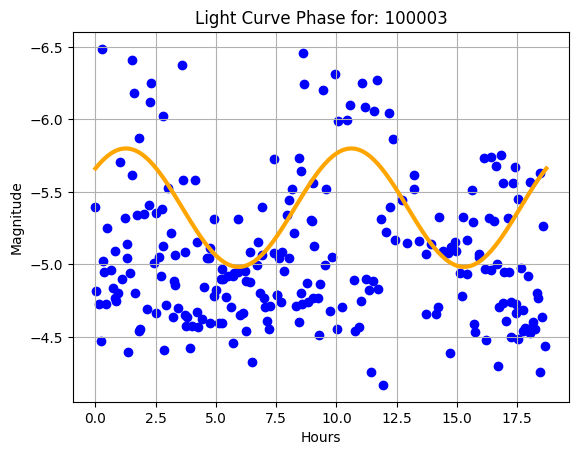

Chi2: -0.8168856129846014
PeakPower: 0.12558479719085913
score: -0.15373749877845536


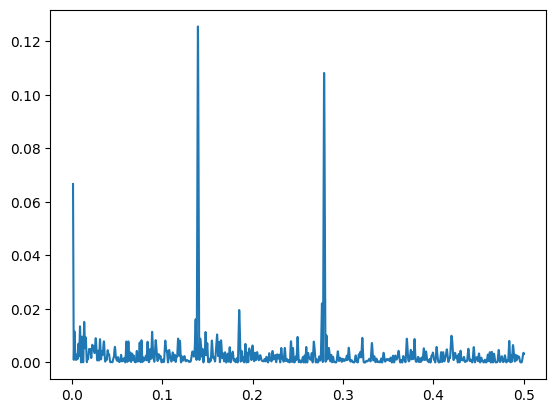

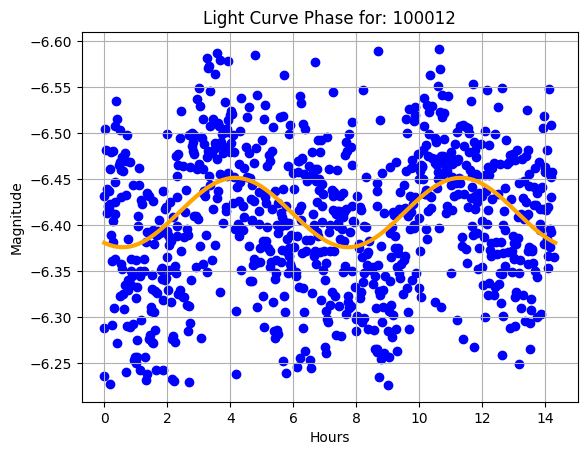

Chi2: -1.0391664144999888
PeakPower: 0.08201472671825263
score: -0.07892461159103896


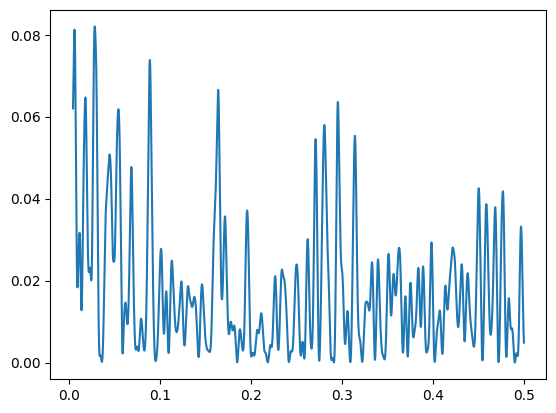

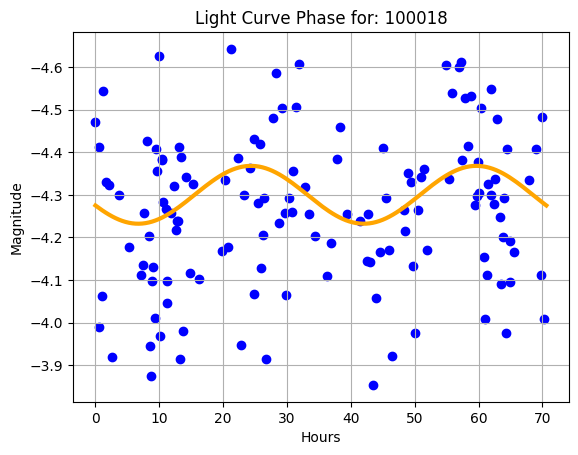

Chi2: -2.74204611230114
PeakPower: 0.22308755119361146
score: -0.08135845402134696


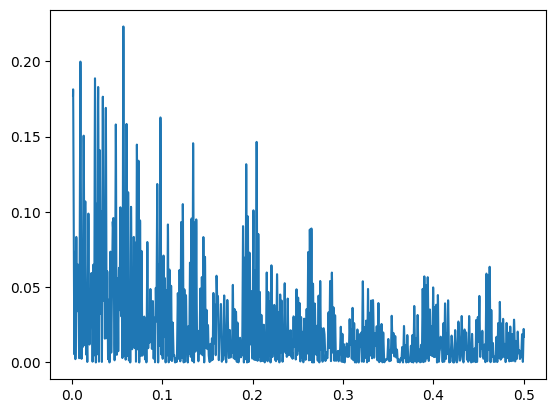

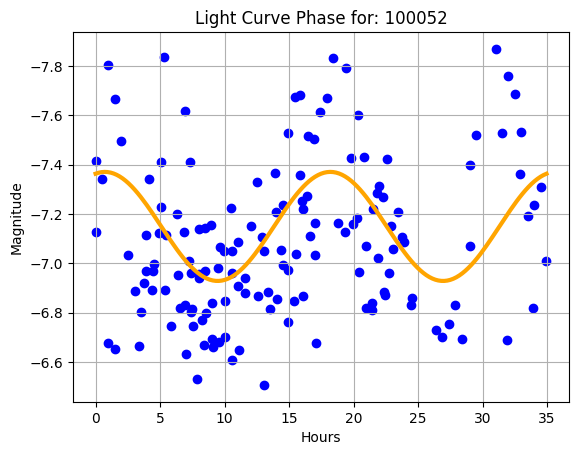

Chi2: -5.163562210911156
PeakPower: 0.08371033011536444
score: -0.016211937206917094


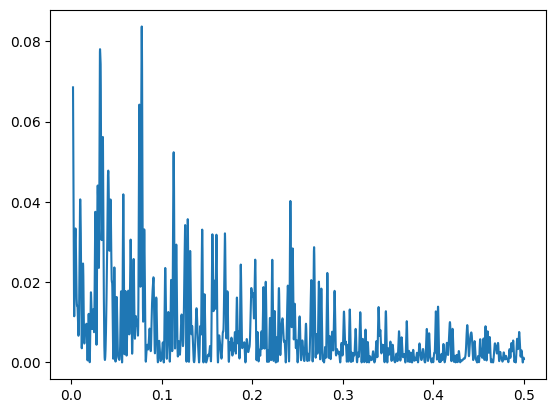

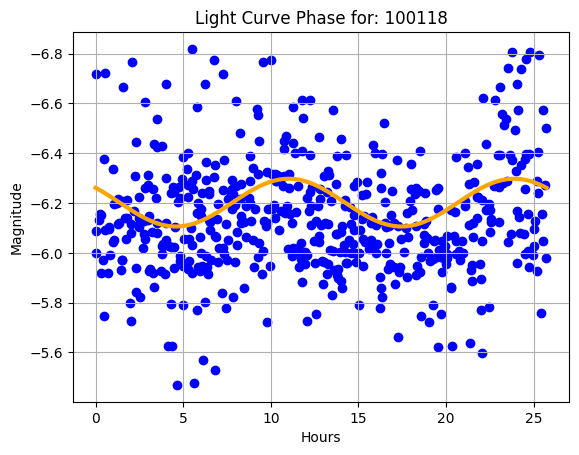

Chi2: -4.449987614093882
PeakPower: 0.4397073865409838
score: -0.09881117061079484


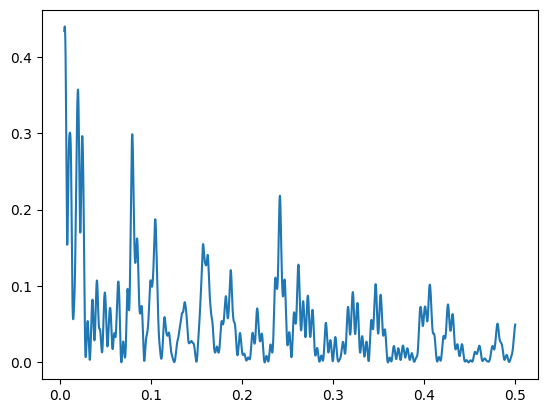

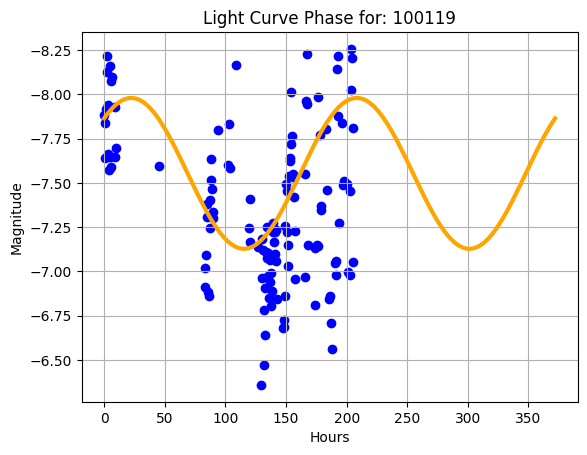

Chi2: -7.024882068532197
PeakPower: 0.12592693904486493
score: -0.01792598875573231


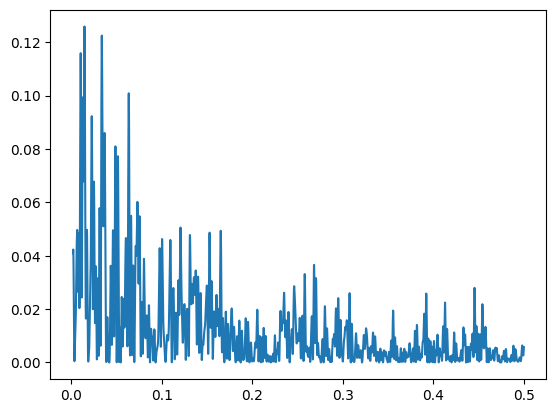

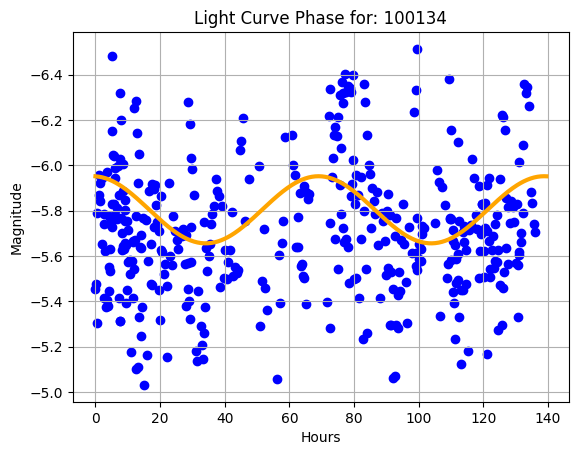

Chi2: -0.7815189722530417
PeakPower: 0.5710641310494904
score: -0.7307127300005196


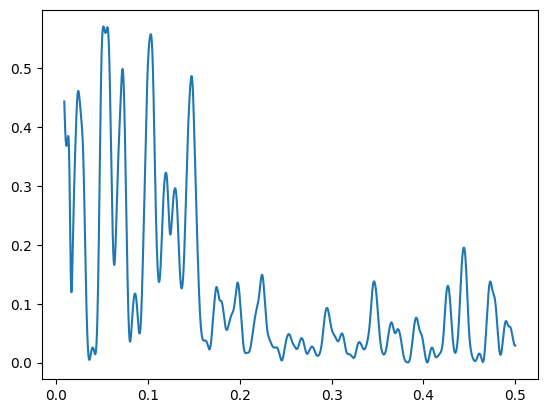

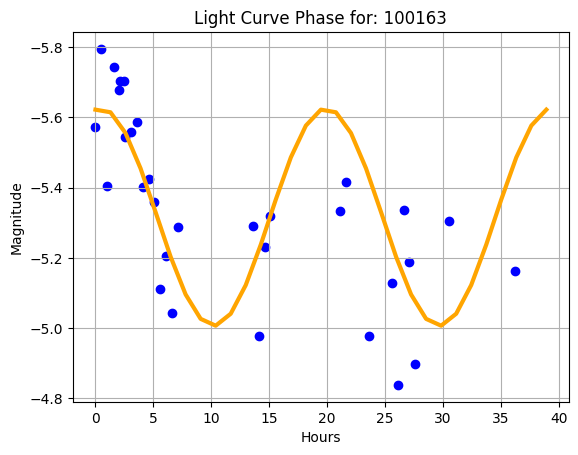

Chi2: -3.1900290457446356
PeakPower: 0.0900749164318202
score: -0.02823671614799052


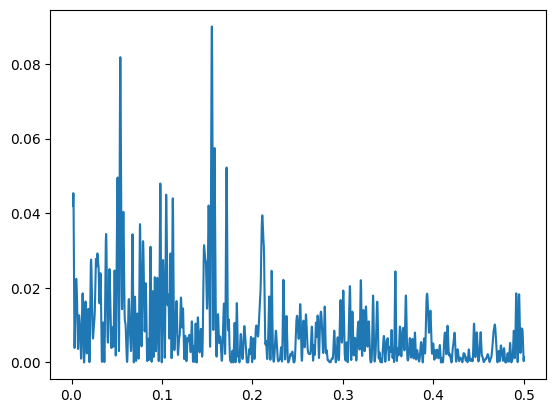

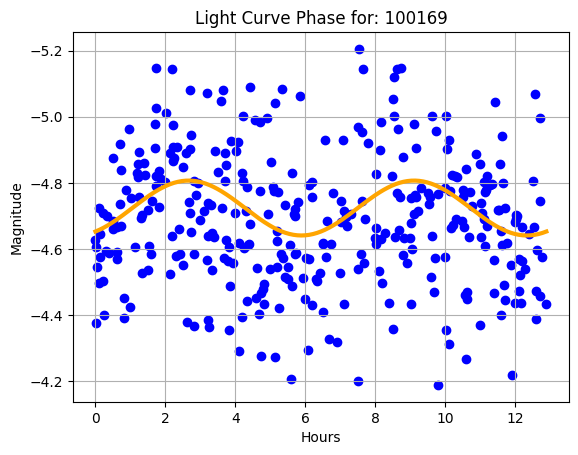

In [16]:
find_cycle_asteroids_light_curve_fit(cycle1_df, "Original_Object_ID")